In [2]:
import sys
import csv
import json
import requests
import requests_cache
import numpy as np
import pandas as pd
from yahoo_finance import Share
from pprint import pprint 
from datetime import datetime
import matplotlib.pyplot as plt

import matplotlib as mpl
%matplotlib inline

import seaborn as sns
sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

import missingno as msno

In [3]:
requests_cache.install_cache('cache')

In [4]:
# Yahoo! YQL API
PUBLIC_API_URL = 'https://query.yahooapis.com/v1/public/yql'
OAUTH_API_URL = 'https://query.yahooapis.com/v1/yql'
DATATABLES_URL = 'store://datatables.org/alltableswithkeys'

def myreq(ticker, start, end):
    '''
    input ticker & dates as strings form 'YYYY-MM-DD'
    '''
    params = {'format':'json',
             'env':DATATABLES_URL}
    query = 'select * from yahoo.finance.historicaldata where symbol = "{}" and startDate = "{}" and endDate = "{}"'.format(ticker,start, end)
    params.update({'q':query})
    req = requests.get(PUBLIC_API_URL, params=params)
    req.raise_for_status()
    req = req.json()
    if req['query']['count'] > 0:
        result = req['query']['results']['quote']
        return result
    else:
        pass

In [5]:
#NEW price function
def price1(length, ticker):
    date=[]
    price=[]
    report = []
    
    c = myreq(ticker,'2016-11-01','2017-03-01')
    try:
        for i in range(0,length):    # (length) USED TO BE 40
            date.append(pd.to_datetime(c[i]["Date"]))
            price.append(float(c[i]["High"]))
            datef = pd.DataFrame(date)
            pricef = pd.DataFrame(price)
            table1 = pd.concat([datef,pricef],axis = 1)
            table1.columns = ['Date', ticker]
            table1 = table1.set_index("Date")
            
    except Exception:
        table1 = pd.DataFrame()
    
    return table1

In [6]:
csv = pd.read_csv('./companylist.csv')
# We want to keep "Finance, Health Care, Technology, Energy"
newcsv = csv[csv["Sector"].isin(["Finance", "Energy","Health Care","Technology"])].reset_index()
del newcsv["index"]

In [7]:
whole_list = newcsv['Symbol']
whole_list

0         PIH
1        FCCY
2        SRCE
3        VNET
4        TWOU
5        JOBS
6        ABEO
7       ABEOW
8        ABIL
9        ABMD
10       AXAS
11       ACIU
12       ACIA
13       ACHC
14       ACAD
15       ACST
16       XLRN
17       ANCX
18       ARAY
19       ACRX
20       ACET
21       AKAO
22       ACHN
23       ACIW
24       ACRS
25       ACNB
26       ACOR
27       ATVI
28       ACTA
29       ACXM
        ...  
1744     WVFC
1745     XBIT
1746     XNCR
1747     XBIO
1748     XBKS
1749     XENE
1750     XLNX
1751     XOMA
1752     XPLR
1753     XTLB
1754     XNET
1755     YHOO
1756     YNDX
1757      YIN
1758       YY
1759     ZFGN
1760     ZAIS
1761     ZBRA
1762     ZLTQ
1763       ZN
1764    ZNWAA
1765     ZION
1766    ZIONW
1767    ZIONZ
1768     ZIOP
1769     ZIXI
1770     ZGNX
1771     ZSAN
1772     ZYNE
1773     ZNGA
Name: Symbol, dtype: object

In [8]:
'''
# The following creates the "main" DF...
# DON'T RUN.

del df #don't run this line if the following loop hasn't been run yet.
for l in whole_list:
    get = price1(82,l)
    try:
        df = pd.concat([df,get],axis = 1)    # concat. by column 
    except NameError:
        df = pd.DataFrame(get)    # initialize automatically
        
'''

'\n# The following creates the "main" DF...\n# DON\'T RUN.\n\ndel df #don\'t run this line if the following loop hasn\'t been run yet.\nfor l in whole_list:\n    get = price1(82,l)\n    try:\n        df = pd.concat([df,get],axis = 1)    # concat. by column \n    except NameError:\n        df = pd.DataFrame(get)    # initialize automatically\n        \n'

In [9]:
# SAVE THE RESULT LOCALLY:
#df.to_pickle('cached_df_presentation.pkl')

# load it back using:
#df = pd.read_pickle('cached_df_presentation.pkl')

In [10]:
df = pd.read_pickle('cached_df_presentation.pkl')

In [11]:
# For the purposes of labeling/analysis, TRANSPOSE() the data frame.
df_long = df.transpose()
# Create a temporary'Symbol' column (necessary later for merging Sector types)
df_long['Symbol'] = df_long.index

In [12]:
#merge in the sector for each ticker
final = newcsv.reset_index()
sector  = final[['Symbol','Sector']]
final = pd.merge(df_long, sector, on = 'Symbol')


In [13]:
# take average within groups for each recorded date:
avg_sector = final.groupby('Sector').mean().reset_index()
avg_sector = avg_sector.set_index('Sector')

In [14]:
# Dates as index for plotting
# This is basically the original DF (transposed and transposed back)
# but the columns are now the Sector averages.
avg_T = avg_sector.transpose()

In [15]:
###Volitility Analysis

# A new DF for the difference between each day:
delta_df = pd.DataFrame()
for sect in avg_T.columns:
    delta_df[sect] = avg_T[sect] - avg_T[sect].shift(1) 
delta_df.columns = map(lambda name: '{} Changes'.format(name),avg_T.columns)

# On what day did the stock price spike the most?
abs(delta_df).idxmax()

Energy Changes        2016-11-30
Finance Changes       2016-11-10
Health Care Changes   2017-02-21
Technology Changes    2016-12-02
dtype: datetime64[ns]

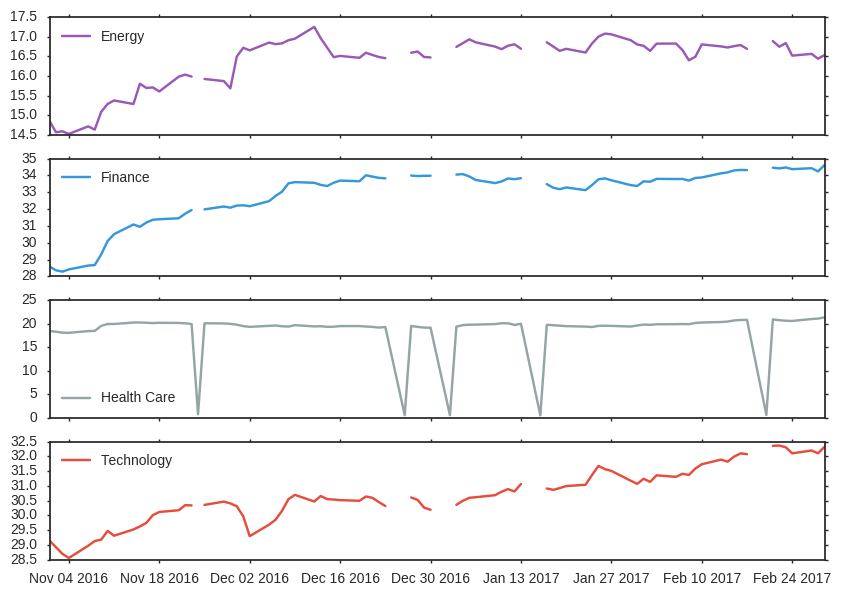

In [16]:
plot_cols = list(avg_T.columns)

# 2 axes for 2 subplots
fig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True)
avg_T[plot_cols].plot(subplots=True, ax=axes)
plt.show()